# Coding Exercise: Model Adaption Meta Learning

In this tutorial, we will implement Model Adaption Meta Learning, to learn a simple curve of sinusoidal data.
If you recall Model Agnostic Meta Learning, consists of 2 loops:
1. To learn parameters for all tasks.
2. To learn task specific parameters

MAML algorithm aims to learn such parameters that can adapt to new tasks with very few examples. 

<img src="Images/parameters.png" width="600"/>


<img src="Images/maml_algo.png" width="500"/>


#### Step 1: Import Libraries 
Let's begin by importing some simple libraries

In [1]:
import math
import random
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

Here we are choosing p(T) as sinsusoidal curve family. So, as next step, we will create a sinsuoidal data points creater function, which will return data points and labels of it.

In [2]:
def generate_dataset(number_of_examples, test=False):
    if test:
        b = math.pi
    else:
        b = 0 if random.choice([True, False]) else math.pi # setting up beta variable randomly
    x = torch.rand(number_of_examples, 1)*4*math.pi - 2*math.pi # randomly generate x datapoints 
    y = torch.sin(x + b) # generate labels in form of sine-curve for randomly generated x
    return x,y

#### Step 2: Create a simple neural network architecture, which is going to learn the sinusoidal curve. 
As mentioned above, we will be getting randomly generated data of sinusoidal curve so, we will be using a simple 2 layer neural network architecture, and as Loss Function we will use L1 loss, as it's a regression exercise.

In [3]:
def NeuralNetwork(x, params):
    x = F.linear(x, params[0], params[1])
    x = F.relu(x)
    x = F.linear(x, params[2], params[3])
    x = F.relu(x)
    x = F.linear(x, params[4], params[5])
    return x

# define Initial Parameters
theta = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

#### step 3: set up parameters for training 
We will be using Stochastic Gradient Descent Optimization Method, and training model using just 5 examples per task.
We can also set it to 1, to make it one-shot learning. 
Here, alpha and beta is a hyper-parameter, can be seen as learning rate. 

In [4]:
alpha, beta = 3e-2, 1e-2 # hyper-paramaters as shown in algorithm above.
opt = torch.optim.SGD(theta, lr=beta) # Optimizer
number_of_examples= 5 # 5-shot learning, 5 examples per task.
iterations = 100000 # number of iterations to enable the model to reach optimal point
epochs = 4 # number of iterations to train task specific model

#### Step 4:  Implement Optimization Algorithm

In [5]:
for it in range(iterations): # training for 1 million iterations
    b = 0 if random.choice([True, False]) else math.pi # setting up beta variable randomly
    
    #### Randomly obtain task 1 sinusoidal data ####
    x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    y = torch.sin(x + b)
    
    #### Randomly obtain the task 2 sinusoidal data ####
    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(v_x + b)

    opt.zero_grad() # setup optimizer

    new_params = theta # initialize weights for inner loop
    for k in range(4):
        f = NeuralNetwork(x, new_params) # re-initialize task 2 neural network with new parameters
        loss = F.l1_loss(f, y) # set loss as L1 Loss

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(theta))] # update weights of inner loop

    v_f = NeuralNetwork(v_x, new_params) # re-initialize task 1 neural network with new parameters
    loss2 = F.l1_loss(v_f, v_y) # calculate Loss
    loss2.backward() # Backward Pass

    opt.step()

    if it % 1000 == 0: 
        print ('Iteration %d Loss %.4f' % (it, loss2))



Iteration 0 Loss 0.7769
Iteration 1000 Loss 0.8167
Iteration 2000 Loss 0.3264
Iteration 3000 Loss 0.6297
Iteration 4000 Loss 0.7330
Iteration 5000 Loss 0.5633
Iteration 6000 Loss 0.6545
Iteration 7000 Loss 0.7192
Iteration 8000 Loss 0.3932
Iteration 9000 Loss 0.8063
Iteration 10000 Loss 0.6289
Iteration 11000 Loss 0.6174
Iteration 12000 Loss 0.7092
Iteration 13000 Loss 0.6059
Iteration 14000 Loss 0.7731
Iteration 15000 Loss 0.4221
Iteration 16000 Loss 0.5452
Iteration 17000 Loss 0.3352
Iteration 18000 Loss 0.3369
Iteration 19000 Loss 0.6712
Iteration 20000 Loss 0.4838
Iteration 21000 Loss 0.4788
Iteration 22000 Loss 0.4932
Iteration 23000 Loss 0.9714
Iteration 24000 Loss 0.3798
Iteration 25000 Loss 0.2735
Iteration 26000 Loss 0.1745
Iteration 27000 Loss 0.1496
Iteration 28000 Loss 0.5535
Iteration 29000 Loss 0.2386
Iteration 30000 Loss 0.2878
Iteration 31000 Loss 0.4920
Iteration 32000 Loss 0.2879
Iteration 33000 Loss 0.1564
Iteration 34000 Loss 0.4612
Iteration 35000 Loss 0.0270
Itera

#### Step 5: Test Model
Once we have obtained right parameters:
1. sample task specific 5 data points.
2. train model with only 5 points and obatin task specific parameters(test_theta)

In [6]:
# Randomly generate 5 data points.
t_b = math.pi 
t_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
t_y = torch.sin(t_x + t_b)

opt.zero_grad()
n_inner_loop = 5
t_params = theta
for k in range(n_inner_loop):
    t_f = NeuralNetwork(t_x, t_params)
    t_loss = F.l1_loss(t_f, t_y)

    grads = torch.autograd.grad(t_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(theta))]

##### Plot the output
Now, we will obtain certain sine curve points for plotting purpose, and observe our trained model.

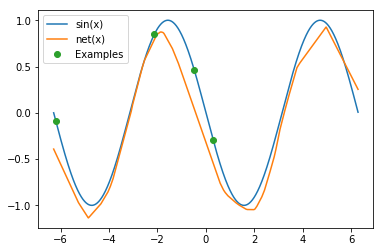

In [7]:
test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
test_y = torch.sin(test_x + t_b)

test_f = NeuralNetwork(test_x, t_params)

plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.plot(t_x.data.numpy(), t_y.data.numpy(), 'o', label='Examples')
plt.legend()
plt.savefig('maml-sine.png')